# Sample a GPyTorch likelihood with emcee

Here we try **and fail** to sample a GPyTorch likelihood functin with emcee.

In [1]:
import gpytorch
import celerite
import emcee
import torch
import multiprocessing
ncpus = multiprocessing.cpu_count()

In [2]:
gpytorch.__version__, celerite.__version__, emcee.__version__, torch.__version__, ncpus

('0.3.6', '0.3.1', '0.4.1', '3.0.0', '1.3.0', 8)

We'll need some other standard and astronomy-specific imports and configurations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generate a draw from a GP with known properties.

In [4]:
from celerite import terms

In [5]:
true_rho = 1.5
true_sigma = 1.2

In [6]:
true_log_sigma = np.log(true_sigma)
true_log_rho = np.log(true_rho)  # Has units of time, so 1/f

In [7]:
kernel_matern = terms.Matern32Term(log_sigma=true_log_sigma, log_rho=true_log_rho, eps=0.00001)

In [8]:
t_vec = np.linspace(0, 40, 500)

In [9]:
gp = celerite.GP(kernel_matern, mean=0, fit_mean=True)
gp.compute(t_vec)
y_true = gp.sample()

In [10]:
#y_true = 0.2*t_vec**2 + 0.3* t_vec - 7.0

In [11]:
noise = np.random.normal(0, 0.3, size=len(y_true))
y_obs = y_true + noise

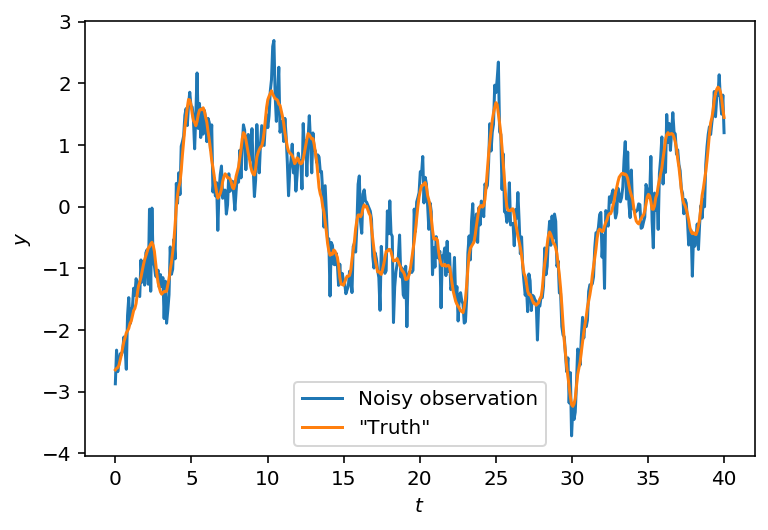

In [12]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='"Truth"')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

# GPyTorch model and GP likelihood building

Basic model building in GPyTorch

In [13]:
import torch

In [14]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)

In [15]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [16]:
model.train()
likelihood.train();

#### Make the **marginal log likelihood**.

In [17]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#### Initialize

In [18]:
init_dict = {'likelihood.noise_covar.raw_noise':torch.tensor([0.28]),
             'mean_module.constant':torch.tensor([0.0]),
             'covar_module.raw_outputscale': torch.tensor(1.18),
             'covar_module.base_kernel.raw_lengthscale': torch.tensor([[1.55]])}

In [19]:
model.initialize(**init_dict);

## MCMC Sample with emcee, with *no gradient* information

In [20]:
def lnlike(params):
    try:
        update_params = {'likelihood.noise_covar.raw_noise':torch.tensor([params[0]]),
                     'mean_module.constant':torch.tensor([params[1]]),
                     'covar_module.raw_outputscale': torch.tensor(params[2]),
                     'covar_module.base_kernel.raw_lengthscale': torch.tensor([[params[3]]])}
        model.load_state_dict(update_params)
        #model.initialize(**update_params)
        mvn_output = model(train_x)
        lnlike_scalar = mll(mvn_output, train_y)
        numpy_lnlike = lnlike_scalar.detach().numpy()
        if numpy_lnlike != numpy_lnlike:
            return -np.inf
        else:
            return numpy_lnlike
    except:
        return -np.inf

Try it with an input vector:

In [21]:
vec_in = np.array([0.2800, 0, 1.19, 1.55])

In [22]:
lnlike(vec_in)

array(-1.0471338, dtype=float32)

Set number of walkers.

In [23]:
ndim, nwalkers = 4, 40
p0 = vec_in+np.random.normal(0.0, 0.01, size=(nwalkers, ndim))

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=ncpus)

You get lots of CG tolerance warnings.  Let's turn these off!

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
state = sampler.run_mcmc(p0, 1000, progress=True);

100%|██████████| 1000/1000 [51:14<00:00,  3.07s/it]


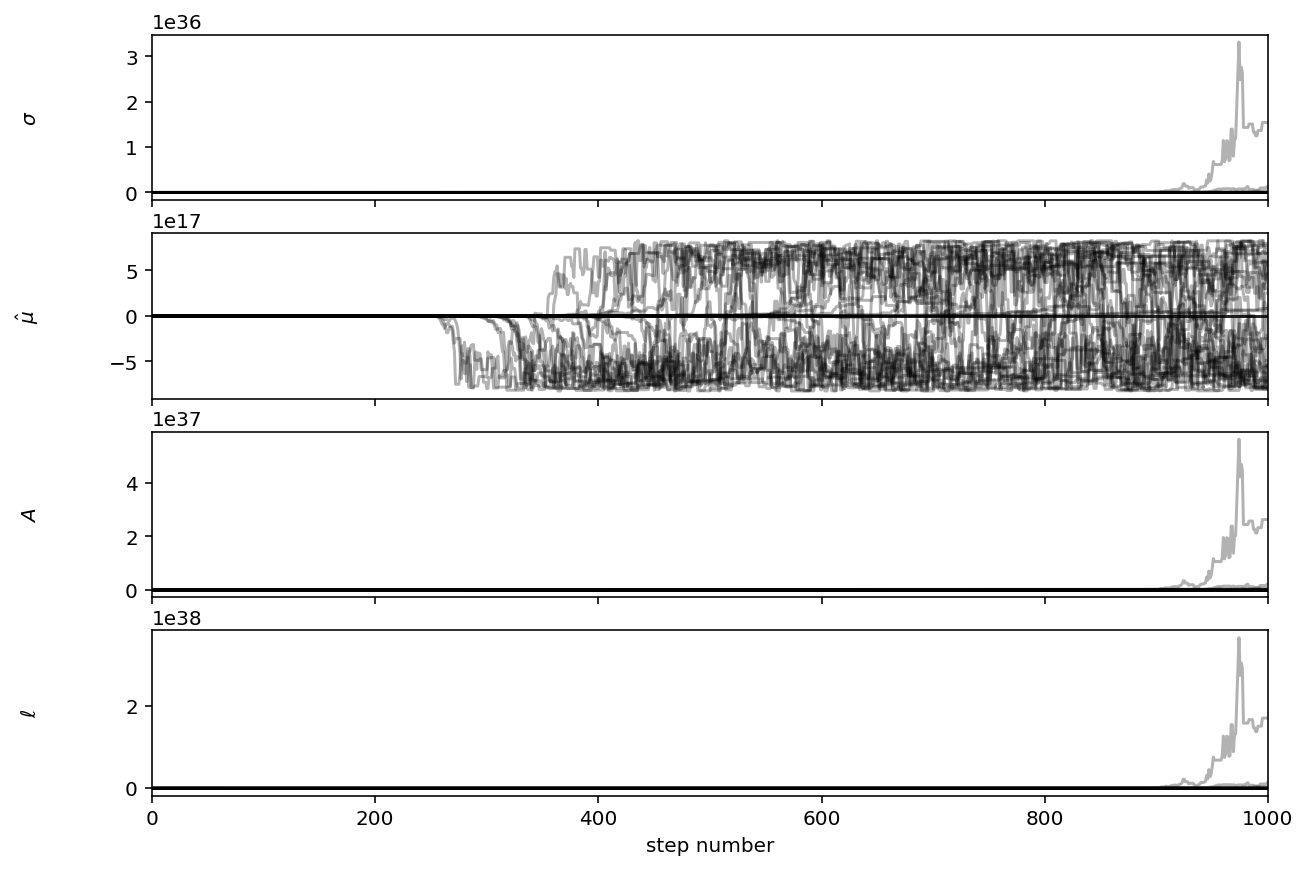

In [27]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\sigma$", "$\hat \mu$", "$A$", "$\ell$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Total fail!!!